# C964 Computer Science Capstone
## Machine Learning Project
### Jeff Fenwick
---

*The following packages will need to be installed along with Python*
* wheel
* pandas
* matplotlib
* pyarrow
* ipywidgets
* numpy
---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

### The CSV file containing the data is imported as a data frame with pandas

In [2]:
dataset = pd.read_csv("ds_salaries.csv")

*The Salary and Salary Currency columns are removed since there is a Salary in USD column which will be used and makes these columns redundant. The unamed index column should also be removed because it is not needed.*

In [3]:
columns_to_drop = ['salary', 'salary_currency']
unnamed_columns_to_drop = [col for col in dataset.columns if 'Unnamed' in col]
dataset = dataset.drop(columns=unnamed_columns_to_drop)
for column in columns_to_drop:
    if column in dataset.columns:
        dataset = dataset.drop(columns=[column])
for columns in dataset:
    print(columns)

work_year
experience_level
employment_type
job_title
salary_in_usd
employee_residence
remote_ratio
company_location
company_size


---
### Cleaning the Data

The data contains some very high salaries which will affect the visualizations and the algorithm, therefore preprocessing or cleaning the data is necessary. Only the column with salary in USD is used since it is standardized.

*This process creates a new data frame that eliminates the ultra-high salaries while keeping all of the lower ones as these don't fall outside of a normal range. The standard quantile modifier of 1.5 is used and can be increased or decreased to allow more or less data into the data frame.*

In [4]:
def filter_outliers_by_group(dataset, group_column, value_column):
    grouped = dataset.groupby(group_column)
    filtered_groups = []
    for group_name, group_data in grouped:
        Q1_value = group_data[value_column].quantile(0.25)
        Q3_value = group_data[value_column].quantile(0.75)
        IQR_value = Q3_value - Q1_value
        lower_bound_value = Q1_value - 1.5 * IQR_value
        upper_bound_value = Q3_value + 1.5 * IQR_value
        filtered_group = group_data[
            (group_data[value_column] >= lower_bound_value) & (group_data[value_column] <= upper_bound_value)
        ]

        filtered_groups.append(filtered_group)
    dataset_filtered = pd.concat(filtered_groups)

    return dataset_filtered


In [5]:
cleaned_dataset = dataset.copy()
cleaned_dataset = cleaned_dataset[cleaned_dataset['employment_type'] == 'FT']
cleaned_dataset = cleaned_dataset[cleaned_dataset['company_location'] == 'US']

cleaned_dataset = filter_outliers_by_group(cleaned_dataset, 'work_year', 'salary_in_usd')
cleaned_dataset = filter_outliers_by_group(cleaned_dataset, 'experience_level', 'salary_in_usd')
cleaned_dataset = filter_outliers_by_group(cleaned_dataset, 'employee_residence', 'salary_in_usd')
cleaned_dataset = filter_outliers_by_group(cleaned_dataset, 'remote_ratio', 'salary_in_usd')
cleaned_dataset = filter_outliers_by_group(cleaned_dataset, 'company_size', 'salary_in_usd')

original_length = len(dataset)
filtered_length = len(cleaned_dataset)

print(f"Number of entries in the original data: {original_length}")
print(f"Number of entries in the filtered data: {filtered_length}")
print(f"Difference in entries: {original_length - filtered_length}")

Number of entries in the original data: 607
Number of entries in the filtered data: 329
Difference in entries: 278


*Because the higher outliers are so large, the lower threshold goes below 0 to include all of the lower numbers. If the higher outliers were closer to the group, the lower threshold would be higher and may disqualify some values.*

---
### Create Training and Test Sets
*Separate features and target variable.*

In [6]:
X = cleaned_dataset[['work_year', 'experience_level', 'employee_residence', 'remote_ratio', 'company_size']]
y = cleaned_dataset['salary_in_usd']

*Convert categorical variables into dummy/indicator variables.*

In [7]:
X = pd.get_dummies(X, columns=['experience_level', 'employee_residence', 'remote_ratio', 'company_size'], drop_first=True)

*Split the dataset into training and testing sets. The random state is seeded to reproduce scenario for validity.*

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

---
## First Visualization
### Histogram of Salary Ranges

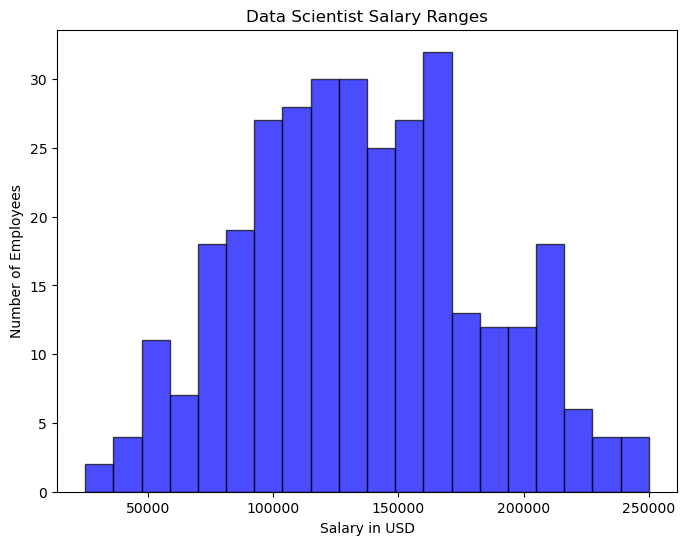

In [9]:
num_bins = 20
plt.figure(figsize=(8,6))
plt.hist(cleaned_dataset['salary_in_usd'], bins=num_bins, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Salary in USD')
plt.ylabel('Number of Employees')
plt.title('Data Scientist Salary Ranges')
plt.show()

---
## Second Visualization
### Scatterplot of Experience vs. Salary
*There are only 4 unique values for experience: EN (entry), MI (middle), SE (senior), EX (expert). The important information is the regression line which shows a direct correlation between experience and salary.*

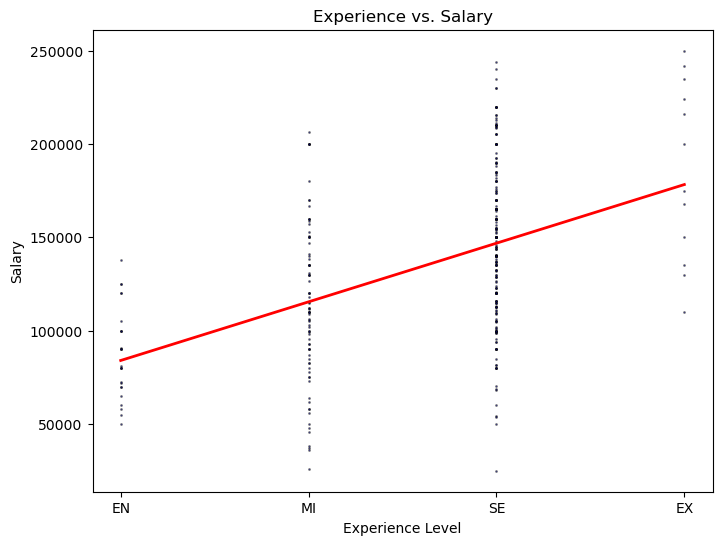

In [10]:
lvl_of_experience = {'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4}
cleaned_dataset_copy = cleaned_dataset.copy()
cleaned_dataset_copy['Level of Experience'] = cleaned_dataset_copy['experience_level'].map(lvl_of_experience)
plt.figure(figsize=(8, 6))
plt.scatter(cleaned_dataset_copy['Level of Experience'], cleaned_dataset_copy['salary_in_usd'], 
            alpha=0.5, color='blue', edgecolors='black', s=1)
plt.xlabel('Experience Level')
plt.ylabel('Salary')
plt.title('Experience vs. Salary')
plt.xticks([1, 2, 3, 4], ['EN', 'MI', 'SE', 'EX'])
least_squares_polynomial_fit = np.polyfit(cleaned_dataset_copy['Level of Experience'], 
                                          cleaned_dataset_copy['salary_in_usd'], 1)
regression_line = np.polyval(least_squares_polynomial_fit, [1, 2, 3, 4])
plt.plot([1, 2, 3, 4], regression_line, 'r', linewidth=2)
plt.show()

---
## Third Visualization
### Bar chart of average salary in different company sizes (small, medium, and large)
*Average is calculated from the cleaned dataset.*

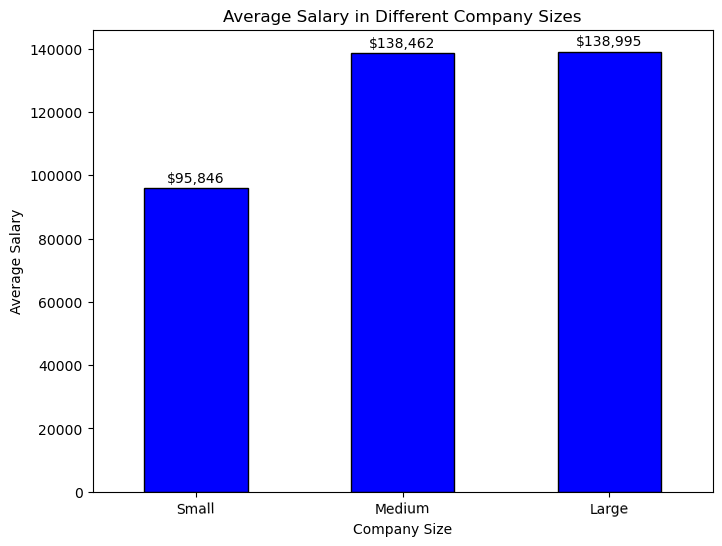

In [11]:
average_salaries = cleaned_dataset.groupby('company_size')['salary_in_usd'].mean().sort_values()
plt.figure(figsize=(8, 6))
bar_plot = average_salaries.plot(kind='bar', color='blue', edgecolor='black')
for idx, value in enumerate(average_salaries):
    formatted_value = '${:,.0f}'.format(value)
    bar_plot.text(idx, value + 1000, formatted_value, ha='center', va='bottom', color='black')
plt.xlabel('Company Size')
plt.ylabel('Average Salary')
plt.title('Average Salary in Different Company Sizes')
plt.xticks(range(len(average_salaries)), ['Small', 'Medium', 'Large'], rotation=1)
plt.show()

In [12]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
intercept = model.intercept_

print("Intercept:", intercept)
print("Coefficients:")
print(coefficients)

Mean Squared Error: 2172203065.457331
R-squared: 0.09575853163117176
Intercept: -2300143.7120344355
Coefficients:
                  Feature   Coefficient
0               work_year  1.156817e+03
1     experience_level_EX  1.095232e+05
2     experience_level_MI  2.915832e+04
3     experience_level_SE  6.059752e+04
4   employee_residence_BO  3.607114e+03
5   employee_residence_BR  4.751669e+04
6   employee_residence_DE  4.718520e+04
7   employee_residence_ES -1.455192e-11
8   employee_residence_FR -3.000000e+04
9   employee_residence_GR -3.209045e+04
10  employee_residence_HU  7.275958e-12
11  employee_residence_IN  3.114578e+04
12  employee_residence_MY  0.000000e+00
13  employee_residence_PH -2.182787e-11
14  employee_residence_PR  9.301246e+04
15  employee_residence_PT  4.786207e+03
16  employee_residence_RO -4.093763e+04
17  employee_residence_RU -1.717621e+03
18  employee_residence_US  6.385876e+04
19  employee_residence_VN -1.397061e+04
20        remote_ratio_50 -9.719022e+03
21    

In [13]:
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
result_df['Difference'] = result_df['Actual'] - result_df['Predicted']
result_df['Actual'] = result_df['Actual'].map("${:,.0f}".format)
result_df['Predicted'] = result_df['Predicted'].map("${:,.0f}".format)
result_df['Difference'] = result_df['Difference'].map("${:,.0f}".format)
print("Frame of Reference for Test Set Predictions:")
print(result_df.head(20))  

Frame of Reference for Test Set Predictions:
       Actual Predicted Difference
348  $113,000  $163,397   $-50,397
228  $135,000  $162,241   $-27,241
102   $36,259   $57,224   $-20,965
168   $55,000   $70,249   $-15,249
422  $159,000  $117,386    $41,614
483  $216,000  $197,751    $18,249
553  $144,000  $148,825    $-4,825
490  $200,000   $84,967   $115,033
342  $224,000  $197,751    $26,249
81   $140,000  $134,095     $5,905
331   $90,320  $148,825   $-58,505
103   $62,000  $130,801   $-68,801
326  $130,000  $197,751   $-67,751
418   $63,900  $114,093   $-50,193
140  $135,000  $134,095       $905
298  $136,620  $148,825   $-12,205
504  $115,000  $148,825   $-33,825
61   $130,800   $51,214    $79,586
419  $160,000  $135,252    $24,748
546  $110,500  $148,825   $-38,325


In [14]:
work_year_widget = widgets.IntSlider(value=2024, min=2023, max=2025, step=1, description='Work Year:')
experience_level_widget = widgets.Dropdown(options=['EN', 'MI', 'SE', 'EX'], value='EN', description='Experience Level:')
input_widgets = [work_year_widget, experience_level_widget]
input_box = widgets.VBox(input_widgets)
layout = widgets.VBox([input_box])

display(layout)